In [1]:
import re
import pickle
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding
from tensorflow.keras.utils import plot_model

In [2]:
model = load_model('chatbot6.h5')

with open('tokenizer6.pickle', 'rb') as temp1:
    tokenizer = pickle.load(temp1)
with open('input_output_shapes6.pickle', 'rb') as temp2:
    len_dict = pickle.load(temp2)


In [3]:
len_dict

{'max_len_ques': 218, 'max_len_answ': 174}

In [4]:
len(tokenizer.word_index)

12671

In [5]:
index2word = {}
word2index = {}
for k,v in tokenizer.word_index.items():
    if v < 19999:
        index2word[v] = k
    if v > 19999:
        continue
    
for k,v in index2word.items():
    word2index[v] = k

len(word2index) == len(index2word)

True

In [6]:
def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()
    
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    
    return text

In [7]:
bos = "<sos>"
eos = " <eos>"
VOCAB_SIZE = len(index2word) + 1

In [8]:
inp_len = len_dict['max_len_ques']
out_len = len_dict['max_len_answ']

In [9]:
def process_input(text, MAX_LEN = inp_len):
    text = [clean_text(text)]
    token_text = tokenizer.texts_to_sequences(text)
    padded_seq = pad_sequences(token_text, maxlen = inp_len, dtype='int32',
                                     padding='post', truncating='post')

    return padded_seq

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 218)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 174)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 218, 50)      633600      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 174, 128)     1622016     input_2[0][0]                    
______________________________________________________________________________________________

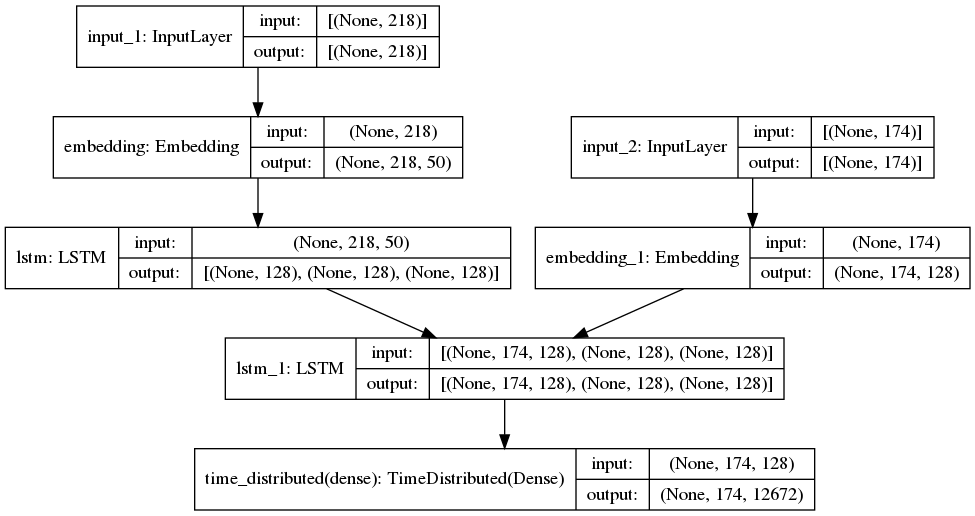

In [11]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [12]:
def create_encmodel(tr_mod, HIDDEN_DIM=128):
    encoder_inputs = tr_mod.input[0]
    encoder_outputs, state_h_enc, state_c_enc = tr_mod.get_layer('lstm').output
    encoder_states = [state_h_enc, state_c_enc]
    encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])

    return encoder_model

In [13]:
def create_decmodel(tr_mod, HIDDEN_DIM = 128):
    decoder_inputs = tr_mod.input[1]
    decoder_state_input_h = Input(shape=(HIDDEN_DIM, ), name='input_3')
    decoder_state_input_c = Input(shape=(HIDDEN_DIM, ), name='input_4')
    dec_state_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    dec_embed = tr_mod.get_layer('embedding_1')(decoder_inputs)
    dec_lstm = tr_mod.get_layer('lstm_1')
    
    dec_outputs, dec_state_h_out, dec_state_c_out = dec_lstm(dec_embed, initial_state=dec_state_inputs)
    dec_state_outputs = [dec_state_h_out, dec_state_c_out]
    decoder_dense = tr_mod.get_layer('time_distributed')
    decoder_outputs = decoder_dense(dec_outputs)
    decoder_model = Model(
    [decoder_inputs,  dec_state_inputs],
    [decoder_outputs] + dec_state_outputs)
    
    return decoder_model

In [14]:
enc_model = create_encmodel(model)
enc_model.compile(optimizer='adam', loss ='categorical_crossentropy', metrics = ['accuracy'])
enc_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 218)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 218, 50)           633600    
_________________________________________________________________
lstm (LSTM)                  [(None, 128), (None, 128) 91648     
Total params: 725,248
Trainable params: 725,248
Non-trainable params: 0
_________________________________________________________________


In [15]:
dec_model = create_decmodel(model)
dec_model.compile(optimizer='adam', loss ='categorical_crossentropy', metrics = ['accuracy'])
dec_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 174)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 174, 128)     1622016     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
____________________________________________________________________________________________

In [16]:
prepro1 =''
while prepro1 != 'q':
    prepro1 = input('> ')
    try:
        states_values = enc_model.predict(process_input(prepro1))
        empty_target = np.zeros((1,1))
        empty_target[0,0] = tokenizer.word_index['<sos>']
        stop_cond = False
        decoded = ''
        while not stop_cond:
            dec_outs, h, c = dec_model.predict([empty_target] + states_values)
            sampled_word_idx = np.argmax(dec_outs[0, -1, :])
            sampled_word = index2word[sampled_word_idx]
            if sampled_word != '<eos>':
                decoded += '{} '.format(sampled_word)
            if (sampled_word == '<eos>') or (len(decoded.split()) > out_len):
                stop_cond = True
            empty_target = np.zeros((1,1))
            empty_target[0,0] = sampled_word_idx
            states_values = [h,c]

        print(decoded)
    except:
        print("Sorry didn't catch what you said,\n could you please repeat that?\n >")
print('Goodbye')

> hello computer, how are you doing today?
i trying to see my name 
> Your name is computer
sure father i am trying to be a martyr 
> How do you know I am your father?
debbie long for life ago already told the damn what would i say 
> Is your name debbie?
what 
> What do you call yourself?
becoming nothing sent bit than you want to remember it to it to it to it to it 
> Stuck in a loop?
his knock eddie 
> who is eddie?
took don 
> eddie took don?
who is he 
> I don't know
becoming nothing proposal 
> Are you suggesting that I die?
not not me up police to do it to be a martyr than a savior 
> q
when i do not know what i get in an hour to the farm so what do you think 
Goodbye


In [27]:
enc_model.predict(process_input(input()))

hello, how are you doing?


[array([[-9.9663919e-01, -4.2795204e-04, -5.9396587e-04,  2.5174706e-04,
          8.2513914e-03,  9.9939102e-01, -3.9359307e-04,  9.9956816e-01,
          3.4808923e-04,  2.5600838e-04, -5.1499084e-03,  3.3175910e-04,
         -1.7081133e-04, -9.9492216e-01, -9.9910742e-01, -9.9946672e-01,
         -2.7752380e-04, -9.9911296e-01, -1.9106616e-03, -5.4345437e-04,
         -2.2621034e-02,  9.5220321e-01, -1.3182996e-01,  9.9932396e-01,
         -9.9965709e-01, -2.5743283e-03,  5.0891761e-04, -1.2798927e-04,
         -5.1919566e-03,  8.9230292e-02, -1.2076292e-03,  9.9925119e-01,
         -9.3423492e-05, -9.9942410e-01,  5.1785767e-04, -9.9958032e-01,
         -9.9899477e-01, -9.9925685e-01, -4.7452899e-04,  1.0021013e-04,
          9.9465358e-01,  9.9938720e-01, -9.9898291e-01, -9.9953079e-01,
         -9.8726141e-01, -9.9509096e-01, -9.9928516e-01, -9.9937457e-01,
          1.2743804e-03,  9.9916428e-01, -9.9914747e-01,  1.5860241e-03,
          1.9774351e-03,  9.8962462e-01,  9.9888426

In [42]:
temp3 = np.zeros((1,out_len))
temp3[0,0] = tokenizer.word_index['start']

In [41]:
tokenizer.word_counts['end']

23788